In [14]:
import numpy as np
from matplotlib.pyplot import imshow , axes
import os
from tensorflow.keras.preprocessing.image import load_img ,img_to_array , ImageDataGenerator
from skimage import transform
import cv2
import itertools
from tensorflow.keras import regularizers
from tensorflow.math import abs


In [15]:
def create_training(x,y , size = 300 , seed = 10000):
    data = []
    label = []
    np.random.seed(seed)
    sample = np.random.choice(range(len(x)) ,size =size)
    x_sample = x[sample]
    y_sample = y[sample]
    tup = [(x1, y1) for x1, y1 in zip(x_sample, y_sample)]
    for a,b in  itertools.product(tup , tup):
        data.append((a[0],b[0]))
        label.append(a[1] == b[1])
    label = np.array(label , dtype = np.int8)
    label = np.argmax(label , axis = 1)
    return np.array(data) , label

In [16]:
datagen = ImageDataGenerator(rescale = 1/255 )

In [17]:
train = datagen.flow_from_directory(r'/content/drive/MyDrive/face_detection/data/images/train' ,
                                target_size = (50,50),
                                 shuffle = True,
                                 seed = 12,
                                 batch_size=20,
                                   color_mode = "grayscale"
                                    )

test = datagen.flow_from_directory(r'/content/drive/MyDrive/face_detection/data/images/val' ,

                                target_size = (50,50),
                                 shuffle = True,
                                 seed = 12,
                                  color_mode = "grayscale" ,
                                 batch_size=8)

Found 275 images belonging to 5 classes.
Found 60 images belonging to 5 classes.


In [18]:
x , y = next(train)
x_train , y_train = create_training(x,y , 20)
x , y = next(test)
x_test, y_test= create_training(x,y , 8)

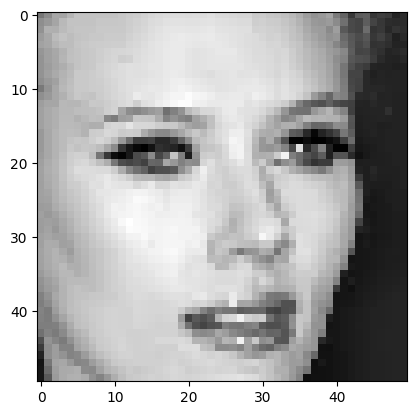

In [19]:
imshow(x_train[50][1] , cmap = 'gray')

In [20]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((50,50), name='img_A_inp')
img_B_inp = Input((50,50), name='img_B_inp')

def get_cnn_block(depth):
    return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((50,50,1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

s = abs(subtract([feature_vector_A , feature_vector_B]))

dense1 = Dense(128, activation='relu' ,kernel_regularizer=regularizers.L2(0.05) ) (s)
dense2 = Dense(64, activation='relu' ,kernel_regularizer=regularizers.L2(0.08) ) (dense1)
dense3 = Dense(8, activation='relu' ,kernel_regularizer=regularizers.L2(0.08) ) (dense2)
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 50, 50)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 50, 50)]     0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 subtract_1 (Subtract)          (None, 64)           0           ['sequential_9[0][0]',     

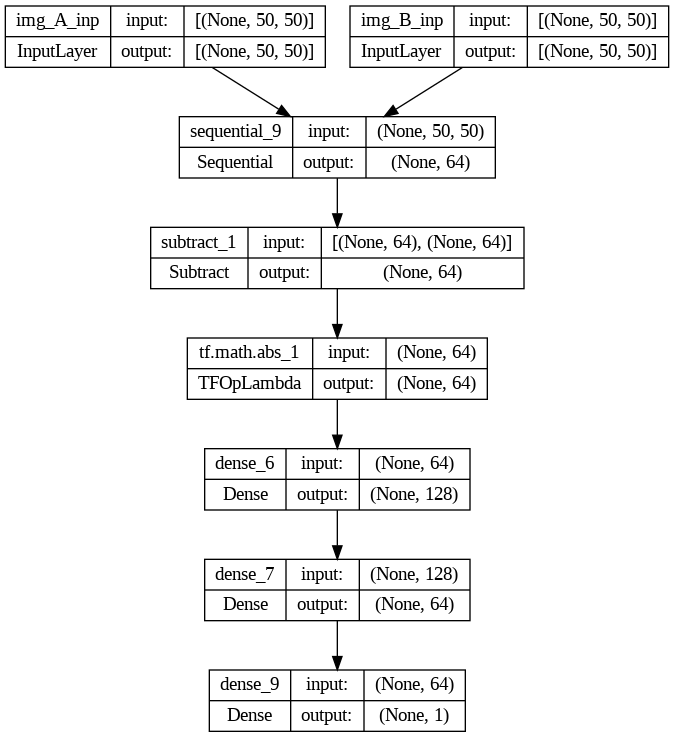

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [22]:
hist = model.fit(x=[x_train[:, 0, :, :],
            x_train[:, 1, :, :]],
          y=y_train,
                 validation_data=([x_test[:, 0, :, : ],x_test[:, 1, :, :]],y_test),
          batch_size=32,
          epochs=10)

Epoch 1/10
13/13 [==============================] - 321s 24s/step - loss: 10.5864 - accuracy: 0.7450 - val_loss: 9.5878 - val_accuracy: 0.6250
Epoch 2/10
13/13 [==============================] - 310s 24s/step - loss: 8.3674 - accuracy: 0.9200 - val_loss: 7.8477 - val_accuracy: 0.6250
Epoch 3/10
13/13 [==============================] - 308s 24s/step - loss: 6.5369 - accuracy: 0.9575 - val_loss: 6.5605 - val_accuracy: 0.6250
Epoch 4/10
13/13 [==============================] - 306s 24s/step - loss: 5.0572 - accuracy: 0.9450 - val_loss: 5.7263 - val_accuracy: 0.6250
Epoch 5/10
13/13 [==============================] - 307s 24s/step - loss: 3.8370 - accuracy: 0.9475 - val_loss: 5.3240 - val_accuracy: 0.6250
Epoch 6/10
13/13 [==============================] - 311s 24s/step - loss: 2.9920 - accuracy: 0.9100 - val_loss: 4.2066 - val_accuracy: 0.6250
Epoch 7/10
13/13 [==============================] - 315s 24s/step - loss: 2.2065 - accuracy: 0.9250 - val_loss: 5.5637 - val_accuracy: 0.6250
Epoch